# CS 418 STRAWHATS


Akhil Abraham, Akhila Abraham, Amal Johnson, Vishal Patel, Gineesh Pillai

# Introduction

Our team is analyzing Chicago Crimes Data to understand the different kinds of crimes in our communities. We are also trying to understand the econmoic factors that contribute to crime by looking at a SocioEconomic Indicator data set. By merging the above two data sets, we hope to get a better understanding of how crime is affected by the various socioeconomic factors particularly employement and income. 

Datasets used: 

Crimes - 2001 to present:
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g
Contains information about crimes from 2001 to present. There are about 8M rows. This data will be filtered down to include years from 2008-present. Contains information about Arrests that has occured, Descriptions of crimes, year and type of crime along with a few others. Many columns will be ommitted as well. 

Census Data - Selected socioeconomic indicators in Chicago, 2008 – 2012: 
https://catalog.data.gov/dataset/census-data-selected-socioeconomic-indicators-in-chicago-2008-2012-36e55
Contains information about communities, education, income levels. 



# Changes

When first starting the project, our group wanted to use the Crimes data set along with CTA Lstops data set to find crimes around CTA stops. After spending several weeks and trying to find a valid common data to be merged on, we realized that merging these two datasets is near impossible. Our group then decided to use our SocioEconomic data set with crimes as they both share columns where the data can be compared and matched with. 

# Data cleaning

The Crimes Data set had about 8 million rows and was extremely large. In order to narrow this down and let this match with our SocioEconomic data set, we filtered the year to start from 2008. The years for both the data sets are from 2008-2020 We also made sure to remove null values and delete a few unwanted columns from both the data sets. The SocioEconomic data set didn't need a lot of removal of the columns. We merged Crime data set along with our SocioEconomic data set leading to about 4million rows worth of data. After Data cleaning, we were able to get 12 years worth of valid data. Some of the columns from the final merged dataframe, we see the locations, descriptions, Arrest along with the community of where these occured. We are also able to see the population, education and income information from the merged data. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.cloud import storage

%load_ext google.cloud.bigquery

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'project-key.json'

Populating all the crimes that has occured at community area 28, which is the "Near West Side" community area. We selected this mainly because we are analyzing crime data in relation to UIC and this is the community that UIC is located at. We also only included domestic crimes to have the list filtered as much as possible.

In [3]:
%%bigquery crimesData

SELECT year, primary_type, description, location_description, district, arrest, COUNT(*) AS Num_Occurance
FROM `bigquery-public-data.chicago_crime.crime` data
WHERE (primary_type != 'OTHER OFFENSE' AND primary_type NOT like '%NON-CRIMINAL%') 
      AND (year <= 2020) AND community_area = 28 AND domestic = true
GROUP BY year, block, primary_type, description, location_description, district, arrest, domestic
ORDER BY year DESC;

In [4]:
crimesData.head()

,year,primary_type,description,location_description,district,arrest,Num_Occurance
0,2020,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,"SCHOOL, PUBLIC, GROUNDS",12,False,1
1,2020,BATTERY,AGGRAVATED DOMESTIC BATTERY - KNIFE / CUTTING ...,APARTMENT,1,True,1
2,2020,BATTERY,AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET S...,ALLEY,11,False,1
3,2020,BATTERY,AGG PO HANDS NO/MIN INJURY,APARTMENT,12,False,1
4,2020,BATTERY,AGGRAVATED OF A SENIOR CITIZEN,APARTMENT,12,False,1


Organizing the Data from socioecon.csv fil which contains data about socio economics for each of the community areas.

In [5]:
rawSocio = pd.read_csv("socioecon.csv")
rawSocio = rawSocio.drop(columns=['HARDSHIP INDEX'])
rawSocio = rawSocio.rename(columns={'Community Area Number': 'Community Area'})
rawSocio = rawSocio[rawSocio['Community Area'].notna()]
rawSocio.tail()

,Community Area,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME
72,73.0,Washington Height,1.1,16.9,20.8,13.7,42.6,19713
73,74.0,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381
74,75.0,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149
75,76.0,O'Hare,3.6,15.4,7.1,10.9,30.3,25828
76,77.0,Edgewater,4.1,18.2,9.2,9.7,23.8,33385


Now we need to get the socio economic data about the area UIC is located at

In [6]:
rawSocio = rawSocio.loc[rawSocio['Community Area'] == 28.0]
rawSocio

,Community Area,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME
27,28.0,Near West Side,3.8,20.6,10.7,9.6,22.2,44689


In [7]:
%%bigquery arrestsData

SELECT primary_type, arrest, COUNT(*) as counts FROM `bigquery-public-data.chicago_crime.crime`
WHERE (primary_type <> 'OTHER OFFENSE' AND primary_type NOT like '%NON-CRIMINAL%') 
AND (year <= 2020) AND community_area = 28 AND domestic = true
GROUP BY primary_type, arrest
ORDER BY primary_type, arrest;


In [8]:
arrestsData.head()

,primary_type,arrest,counts
0,ARSON,False,3
1,ARSON,True,3
2,ASSAULT,False,1501
3,ASSAULT,True,264
4,BATTERY,False,7023


In [9]:
out_filepath=os.path.join("","freq_crime.csv")
crimesData.to_csv(out_filepath,index=False)
#edit made to save and have this uploaded

# Visualization

# The types of crimes

In order to get a basic understanding, a donut chart has been used to show the different types of crimes that are occuring at the Near West Side Community. From this chart you can see that the most occuring crime at the Near West Side Community is Battery with 67.9% in occurance. A table showing the occurances of each of the crimes has also been displayed below as well.

<img src="./visualization/v1.png" />

<img src="./visualization/v1Data.png" />

Text(0.5, 1.0, 'Amount of Arrests Per Crime')

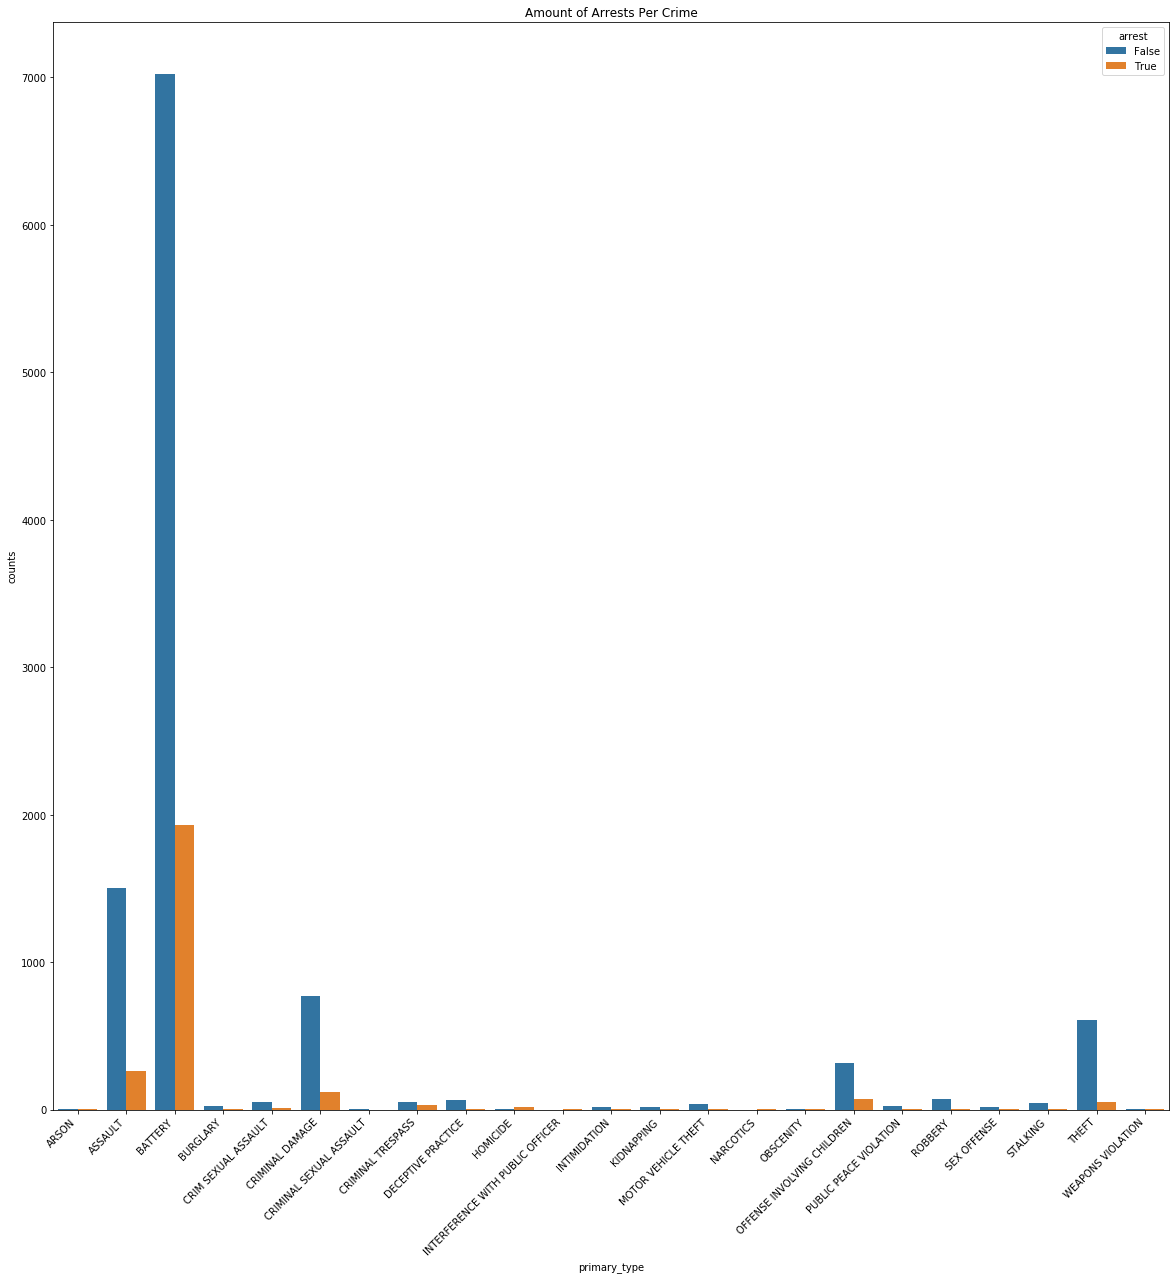

In [10]:
a4_dims = (20, 20)
fig, ax = plt.subplots(figsize=a4_dims)
bar = sns.barplot(x="primary_type",  y="counts",  hue="arrest", data=arrestsData)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.set_palette("viridis")
ax.set_title('Amount of Arrests Per Crime')



# Machine Learning

In [ ]:
X = mergedData['PER CAPITA INCOME '].values.reshape(-1, 1)
crimecnt = mergedData.groupby('Community Area').count()['ID'].reset_index(name="Crime Count")
y = crimecnt['Crime Count'].values
plt.scatter(X, y,  color='Blue')
plt.plot(X_test, y_pred, color='black', linewidth=3)
plt.title('Income v. Crime Count', size=20)
plt.xticks()
plt.yticks()
plt.xlabel('Per Capita Income')
plt.ylabel('Crime Count')
plt.show()

# Reflection

The hardest part for our group has been to find usable data well enough to analyze and merge together. Just finding data took us a couple of weeks and we had to go back and forth with this. 
Our initial insights is that lower income communites have more crime rates and that Unemployment leads to increased crime rates as well. At this point, if we were to plot Income versus crime count, we should be able to see that our hypothesis matches. Going forward, our group will have to dedicate more time to explore the data and create relationships as we spent most of our time trying to find valid data. We made a very good decision in changing our data set to socioEconomic, as now we have valuable valid information. 

# Next Steps

In the next few weeks, our group will work on creating more visualizations exploring the different relationships between the above merged data and use Machine Learning to see whether our hypothesis is accurate. If we can show clear relationships between crime and other social economic factors, we will consider out project to have achieved its goals. 